In [ ]:
## In this file I create the next models: Imagenet-HandPD

# setup for repetitive results
from numpy.random import seed
seed(3)
from tensorflow.random import set_seed
set_seed(2)
import os, sys
from google.colab import drive
drive.mount('/content/mydrive/', force_remount = True)

path = '/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/'
sys.path.insert(0, path)

In [ ]:
# importing necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as C
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import MobileNetV2, InceptionV3, MobileNet, Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

from mpl_toolkits.axes_grid1 import make_axes_locatable
%load_ext tensorboard
C.clear_session()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
test_path = r"/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/MATO/HandPDSpiralk/k_4/test"
train_path = r"/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/MATO/HandPDSpiralk/k_4/train"

In [ ]:
## Preprocessing input 
trdata = ImageDataGenerator(rotation_range=13)
traindata = trdata.flow_from_directory(directory=train_path,target_size=(224,224), class_mode='binary',batch_size=5)
tsdata = ImageDataGenerator(rotation_range=13)
testdata = tsdata.flow_from_directory(directory=test_path, target_size=(224,224), class_mode='binary',batch_size=2)

Found 212 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [ ]:
## Loading VGG16 model as base model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=traindata.image_shape)
base_model.trainable = True

In [ ]:
from tensorflow.keras import layers, models
#  configuring top layers of the model
model = models.Sequential([base_model])
model.add(GlobalAveragePooling2D())
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))

model.add((Dense(1, activation='sigmoid')))

In [ ]:
#  tuning setup for the whole model
C.clear_session()
optimizer = Adadelta(learning_rate=0.05)# choosing appropriate optimizer
# model checkpoint to save weights during training
model_checkpoint = ModelCheckpoint(filepath=path + 'trained_HPDSprial_full_model{epoch:02d}.h5', 
                                   verbose=2,
                                   save_best_only=False,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
logs = r'/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/logs/HPD_logs'
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['binary_accuracy',],) #model compile with choosen settings
#  reducing learning rate for better model fit perfomance
reduce_learning_rate = ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=3, verbose=1, min_delta=0.00005, cooldown=0, min_lr=0.000000001)
# fitting the model on the tarining data with further evaluation on the test data during training process
hist = model.fit_generator(traindata, epochs=50, callbacks=[model_checkpoint, reduce_learning_rate], validation_data=testdata, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 0.8014 - binary_accuracy: 0.6321
Epoch 1: saving model to /content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/trained_HPDSprial_full_model01.h5
43/43 [==============================] - 11s 226ms/step - loss: 0.8014 - binary_accuracy: 0.6321 - val_loss: 0.4350 - val_binary_accuracy: 0.7692 - lr: 0.0500
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.4382 - binary_accuracy: 0.7642
Epoch 2: saving model to /content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/trained_HPDSprial_full_model02.h5
43/43 [==============================] - 9s 215ms/step - loss: 0.4382 - binary_accuracy: 0.7642 - val_loss: 0.3970 - val_binary_accuracy: 0.7692 - lr: 0.0500
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.4265 - binary_accuracy: 0.7783
Epoch 3: saving model to /content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/trained_HPDSprial_full_model03.h5
43/43 [==============================]

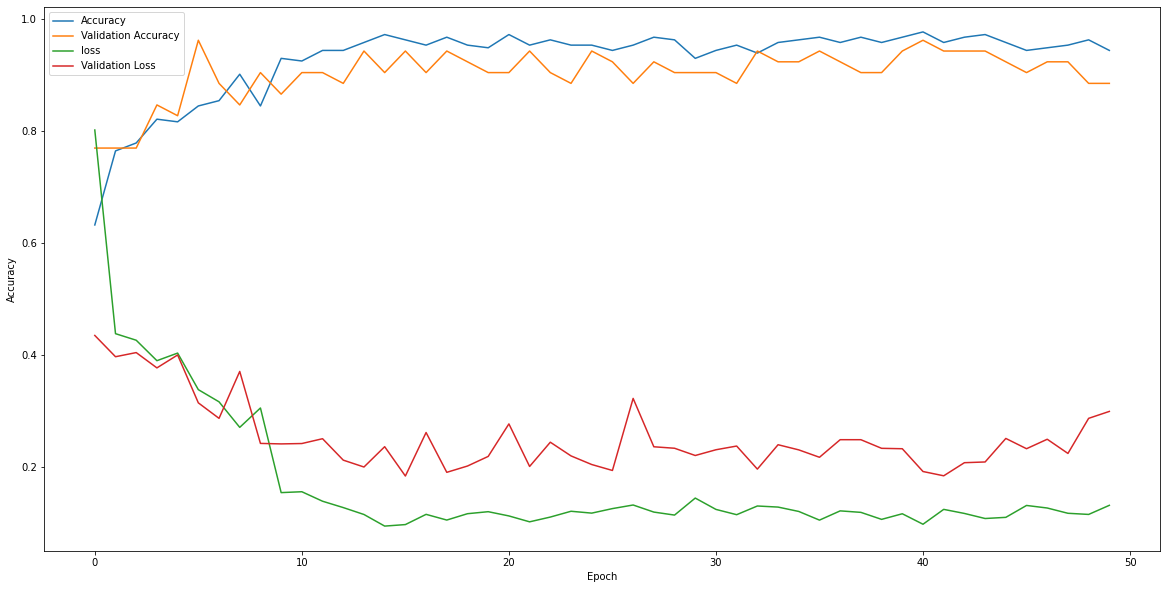

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(hist.history["binary_accuracy"], label='binary_accuracy')
plt.plot(hist.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.savefig('/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/results/Imagenet-Pahaw(HPDSprial)_learning_history.svg')
plt.show()


In [ ]:
# extracting statistics from stored mediator dataset models
import os
from tensorflow import keras
path = r'/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/models/'
files = [file for _, _, file in os.walk(path)][0]

# collecting of model names from data storage to the lists
PAHAW_models = [file  for file in files if file[0:19] == "trained_MNIST_PAHAW"]
# dictionaries for calculated statictics
PAHAW_weights = {}
PAHAW_weights_average = {}
PAHAW_weights_min = {}
PAHAW_weights_max = {}
PAHAW_weights_std = {}
# defining final layer numbers without globalaveragepooling layer and dropout layer
layer_numbers = [2,4]
all_weights = []
PAHAW_weights_ = {}
PAHAW_models.sort()
# cycle for calculating statistics through received models
for idx, file in enumerate(PAHAW_models):
    loaded_model = keras.models.load_model(path + file)
    weights_arr_average = []
    weights_arr_min = []
    weights_arr_max = []
    weights_arr_std = []
    base_model = loaded_model.layers[0]
    for layer_number, layer in enumerate(base_model.get_weights()):

        try:
            layer_weights = base_model.layers[layer_number].trainable_weights[0]
            weights_arr_max.append(np.abs(np.max(layer_weights)))
            weights_arr_min.append(np.abs(np.min(layer_weights)))
            weights_arr_average.append(np.abs((np.max(layer_weights) - np.min(layer_weights)/np.min(layer_weights))))
            weights_arr_std.append(np.abs(np.std(layer_weights)))

        except Exception as e:
            pass

        

    for l in layer_numbers:
        
        layer_weights = loaded_model.layers[l].trainable_weights[0]
        weights_arr_max.append(np.abs(np.max(layer_weights)))
        weights_arr_min.append(np.abs(np.min(layer_weights)))
        weights_arr_average.append(np.abs((np.max(layer_weights) - np.min(layer_weights)/np.min(layer_weights))))
        weights_arr_std.append(np.abs(np.std(layer_weights)))

    print(int(file[-5:-3]))
    PAHAW_weights_average[int(file[-5:-3])] = weights_arr_average
    PAHAW_weights_min[int(file[-5:-3])] = weights_arr_min
    PAHAW_weights_max[int(file[-5:-3])] = weights_arr_max
    PAHAW_weights_std[int(file[-5:-3])] = weights_arr_std


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


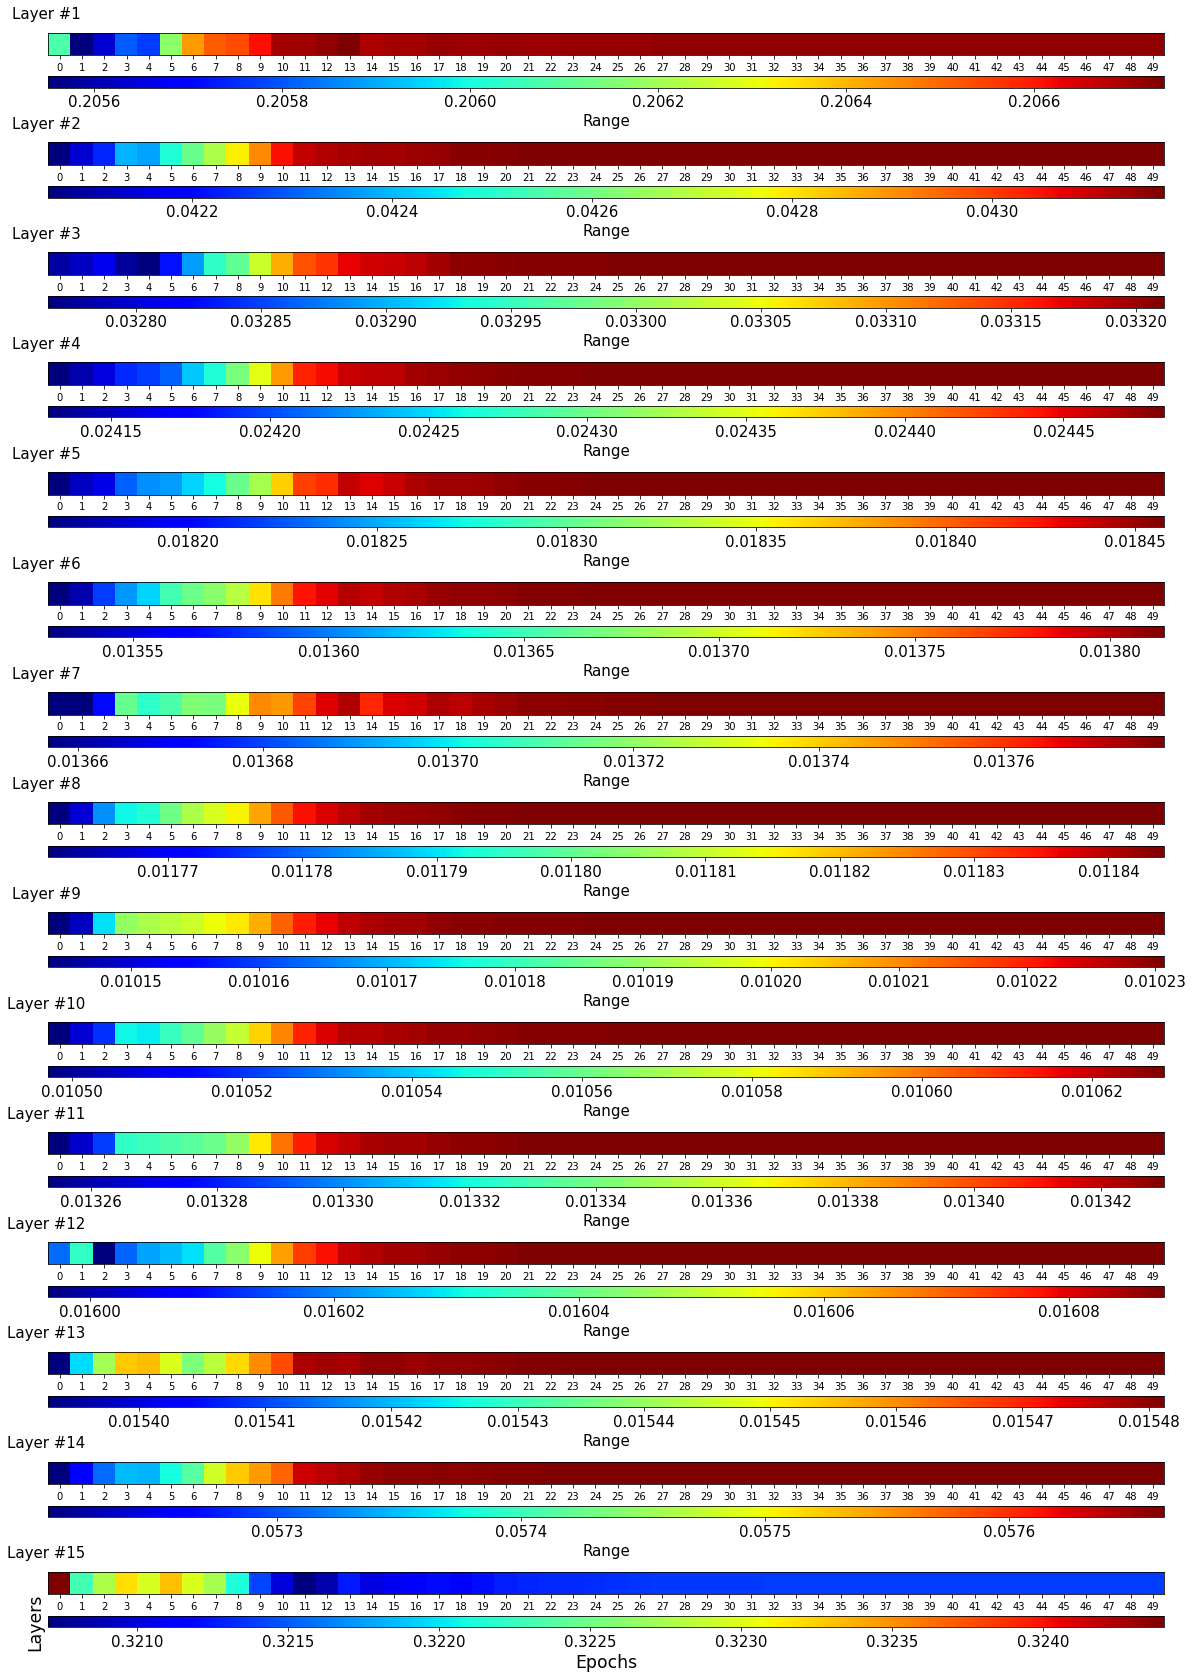

In [ ]:
# visualization of the obtained statistics of the base model
std_weights_array = np.array([ i for i in PAHAW_weights_std.values()]).T
fig, ax = plt.subplots(len(std_weights_array), figsize=(20,30))
results_path = r'/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/results/'

for idx, layer_weights in enumerate(std_weights_array):

    img = ax[idx].imshow([layer_weights], cmap='jet')
    label = ax[idx].set_ylabel(f'Layer #{idx+1}',rotation = 'horizontal',fontsize=15,labelpad = 2.0)
    label.set_position((1,1.5))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_xticks(range(50))
    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="50%", pad=0.3)
    cbar = fig.colorbar(img, orientation = 'horizontal', cax=cax)
    cbar.set_label("Range",fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    

plt.xlabel("Epochs", fontsize = 'xx-large')
plt.ylabel("Layers", fontsize = 'xx-large')
fig.savefig(results_path +'Imagenet-Pahaw(HPDSprial)_std_weights.svg')
fig.show()
# 

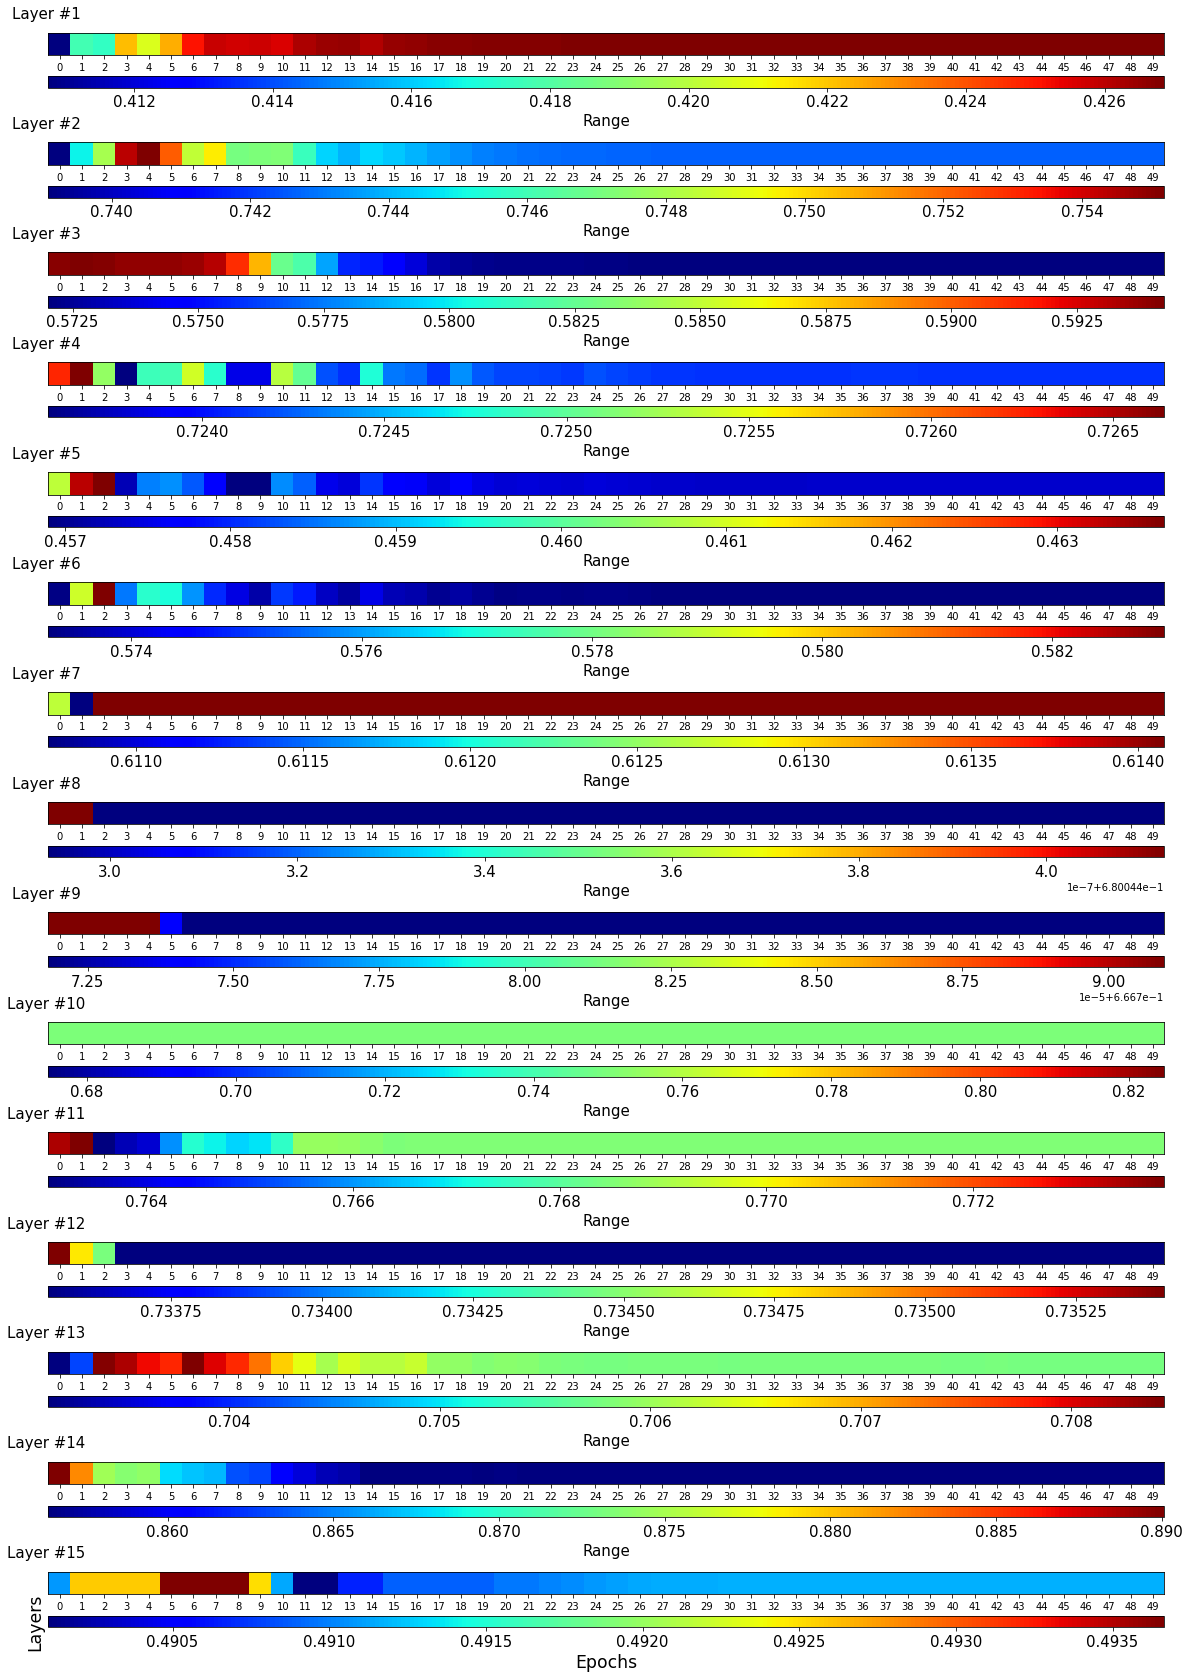

In [ ]:
average_weights_array = np.array([ i for i in PAHAW_weights_average.values()]).T
fig, ax = plt.subplots(len(average_weights_array), figsize=(20,30))


for idx, layer_weights in enumerate(average_weights_array):

    img = ax[idx].imshow([layer_weights], cmap='jet')
    label = ax[idx].set_ylabel(f'Layer #{idx+1}',rotation = 'horizontal',fontsize=15,labelpad = 2.0)
    label.set_position((1,1.5))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_xticks(range(50))
    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="50%", pad=0.3)
    cbar = fig.colorbar(img, orientation = 'horizontal', cax=cax)
    cbar.set_label("Range",fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    

plt.xlabel("Epochs", fontsize = 'xx-large')
plt.ylabel("Layers", fontsize = 'xx-large')
fig.savefig(results_path +'Imagenet-Pahaw(HPDSprial)_average_weights.svg')
fig.show()
# 

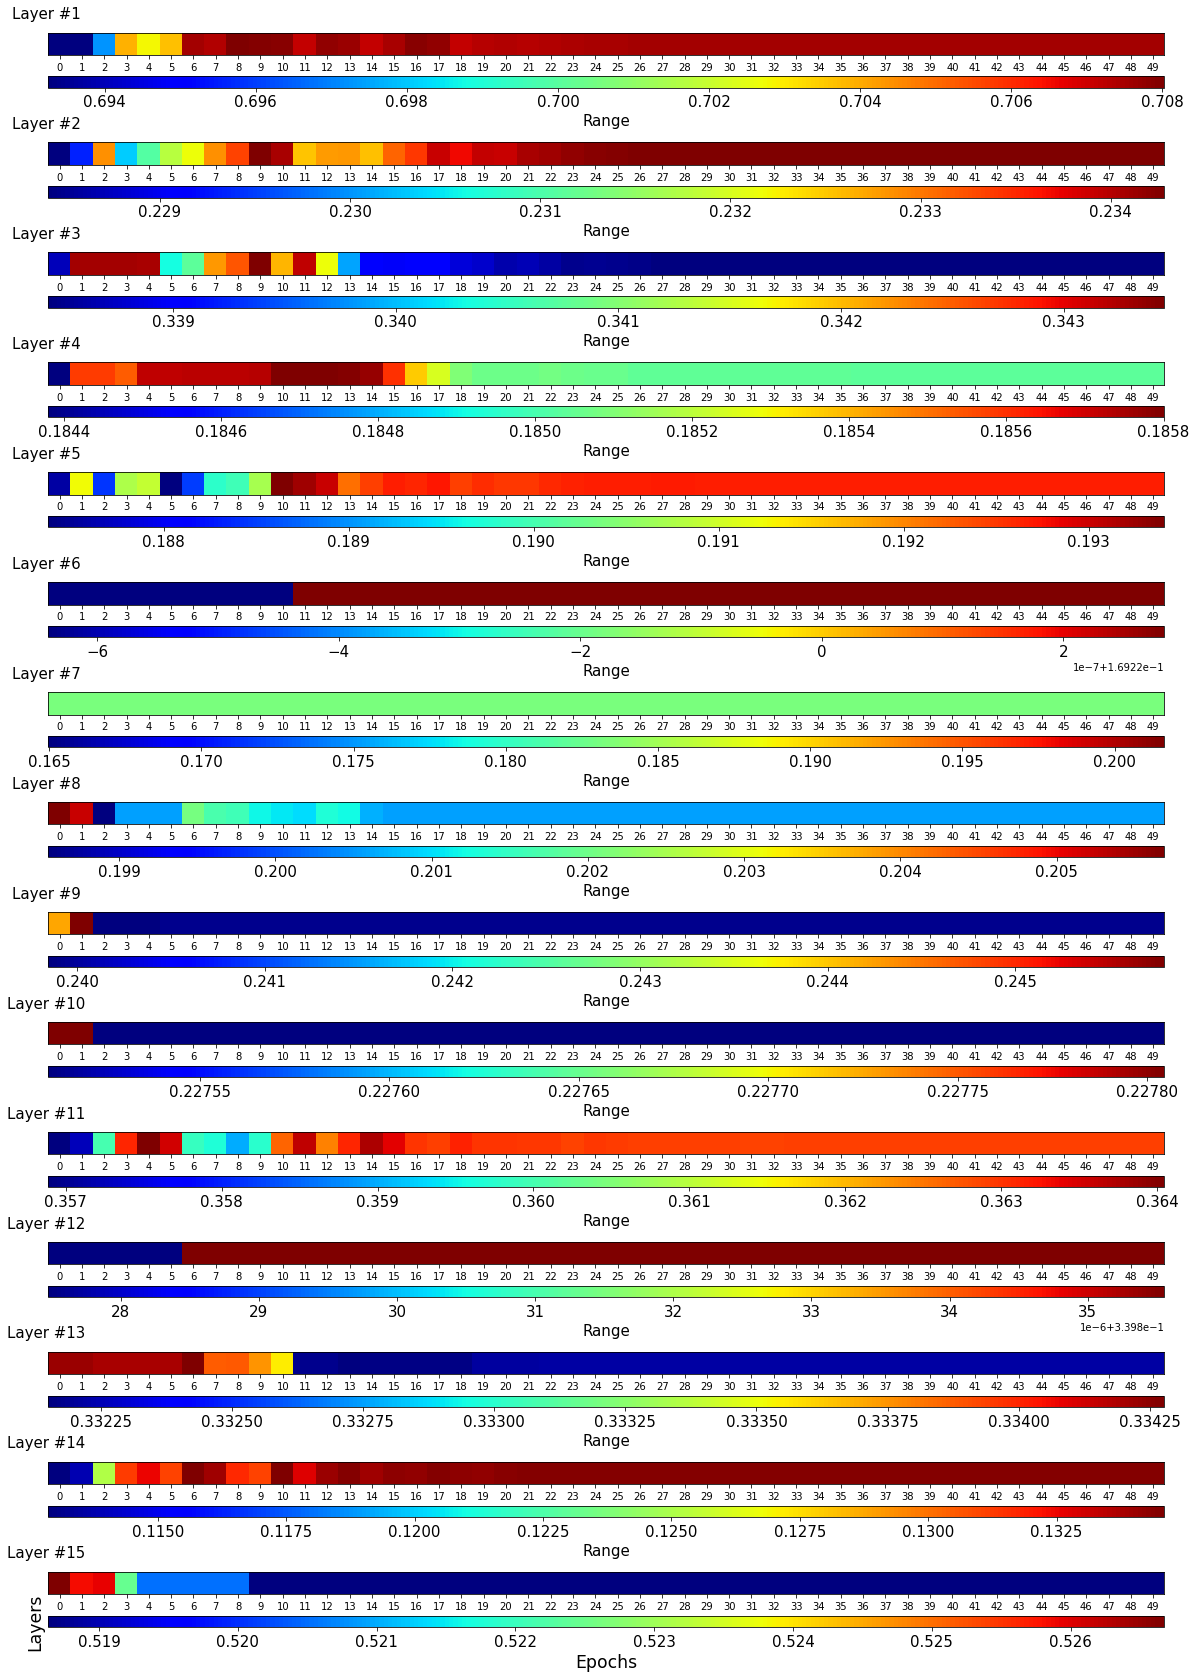

In [ ]:
min_weights_array = np.array([ i for i in PAHAW_weights_min.values()]).T
fig, ax = plt.subplots(len(std_weights_array), figsize=(20,30))


for idx, layer_weights in enumerate(min_weights_array):

    img = ax[idx].imshow([layer_weights], cmap='jet')
    label = ax[idx].set_ylabel(f'Layer #{idx+1}',rotation = 'horizontal',fontsize=15,labelpad = 2.0)
    label.set_position((1,1.5))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_xticks(range(50))
    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="50%", pad=0.3)
    cbar = fig.colorbar(img, orientation = 'horizontal', cax=cax)
    cbar.set_label("Range",fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    

plt.xlabel("Epochs", fontsize = 'xx-large')
plt.ylabel("Layers", fontsize = 'xx-large')
fig.savefig(results_path + 'Imagenet-Pahaw(HPDSprial)_min_weights.svg')
fig.show()
# 

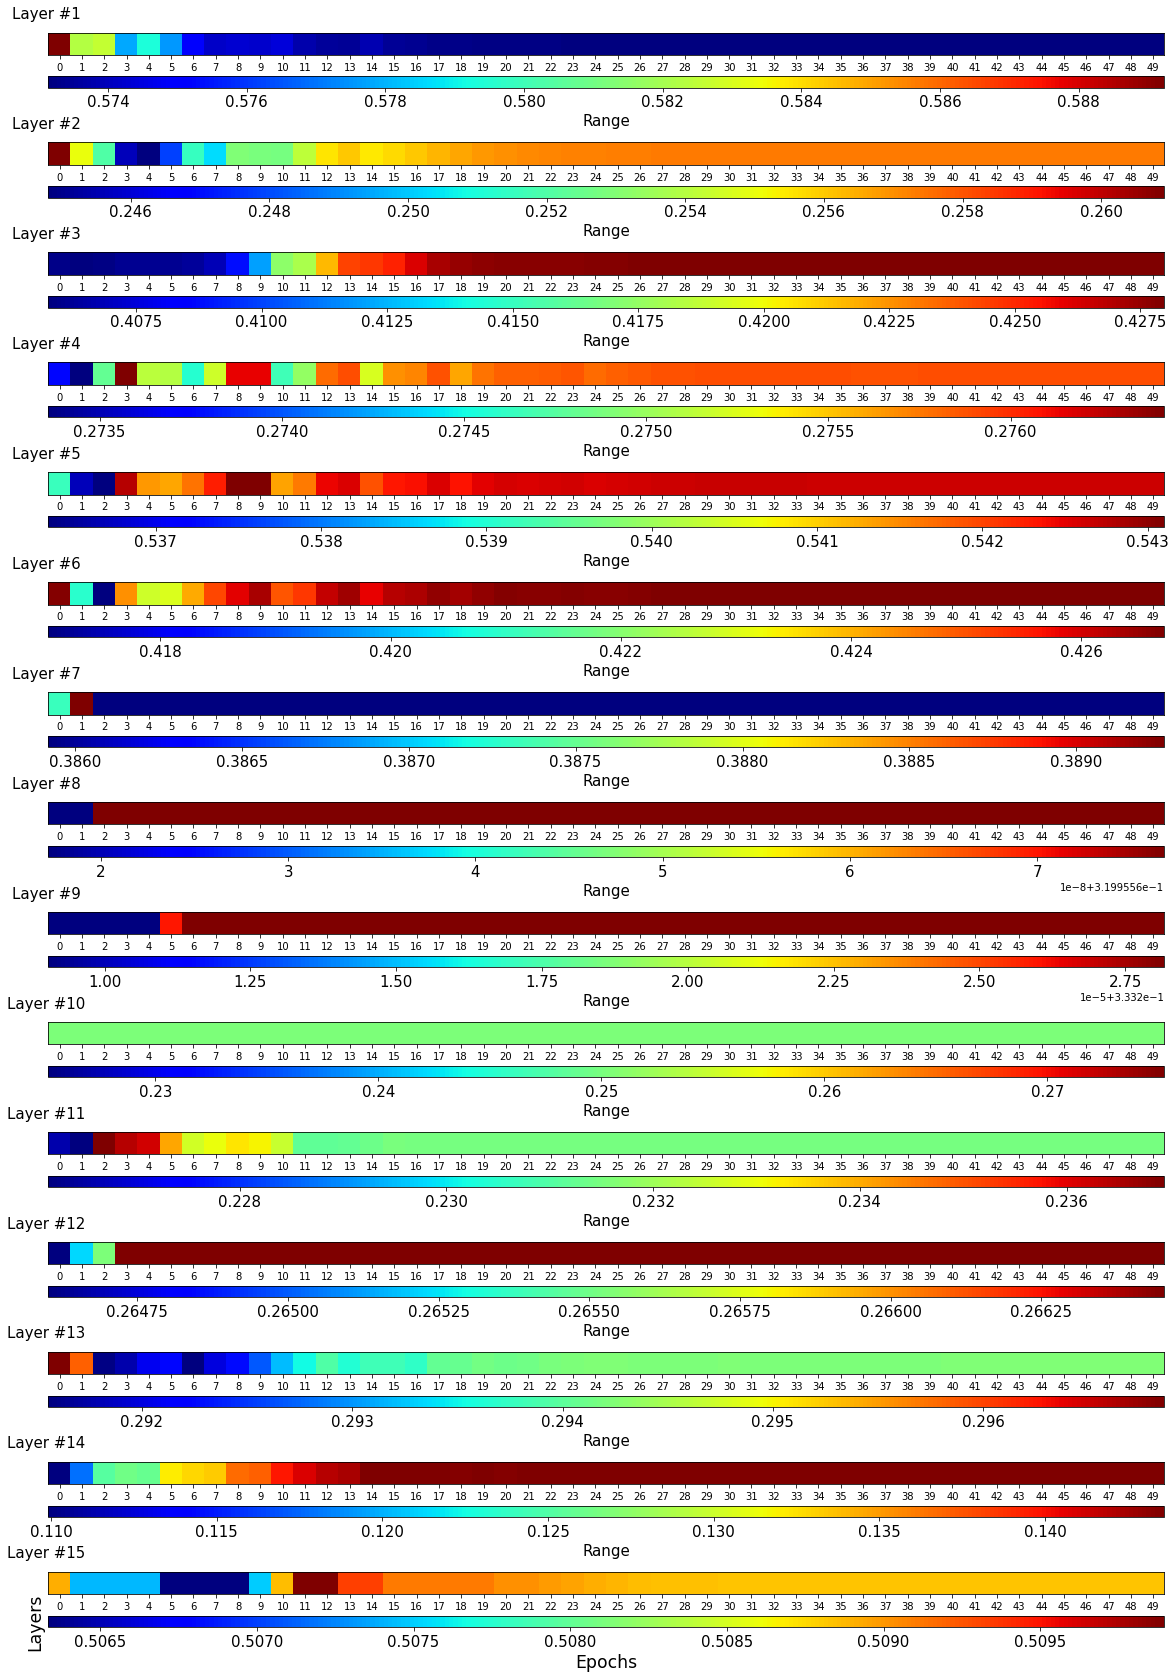

In [ ]:
max_weights_array = np.array([ i for i in PAHAW_weights_max.values()]).T
fig, ax = plt.subplots(len(max_weights_array), figsize=(20,30))


for idx, layer_weights in enumerate(max_weights_array):

    img = ax[idx].imshow([layer_weights], cmap='jet')
    label = ax[idx].set_ylabel(f'Layer #{idx+1}',rotation = 'horizontal',fontsize=15,labelpad = 2.0)
    label.set_position((1,1.5))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_xticks(range(50))
    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="50%", pad=0.3)
    cbar = fig.colorbar(img, orientation = 'horizontal', cax=cax)
    cbar.set_label("Range",fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    

plt.xlabel("Epochs", fontsize = 'xx-large')
plt.ylabel("Layers", fontsize = 'xx-large')
fig.savefig(results_path +'Imagenet-Pahaw(HPDSprial)_max_weights.svg')
fig.show()
# 